<a href="https://colab.research.google.com/github/PreethiEdara/EV_Market_Segmentation/blob/main/EV_Market_Segmentation_preethi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%pip install plotly==5.8.0
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sb
import statsmodels.api as sm
import plotly.express as px
from google.colab import files
%pip install kaleido
import kaleido
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from collections import Counter
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import metrics
from sklearn.metrics import r2_score,silhouette_score,confusion_matrix,accuracy_score
pd.set_option("display.precision",3)
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = '{:.4f}'.format
import plotly.io as pio

pio.renderers.default = "svg"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 70.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00


## Read the data

In [2]:
from google.colab import files
upload=files.upload()

Saving ElectricCarData_Clean.csv to ElectricCarData_Clean.csv


In [5]:
df = pd.read_csv('ElectricCarData_Clean.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)
df['inr(10e3)'] = df['PriceEuro']*0.08320
df['RapidCharge'].replace(to_replace=['No','Yes'],value=[0, 1],inplace=True)
df.head()

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,inr(10e3)
0,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,Sedan,D,5,55480,4615.9360
1,Volkswagen,ID.3 Pure,10.0000,160,270,167,250,1,RWD,Type 2 CCS,Hatchback,C,5,30000,2496.0000
2,Polestar,2,4.7000,210,400,181,620,1,AWD,Type 2 CCS,Liftback,D,5,56440,4695.8080
3,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,SUV,D,5,68040,5660.9280
4,Honda,e,9.5000,145,170,168,190,1,RWD,Type 2 CCS,Hatchback,B,4,32997,2745.3504


In [6]:
df[(df['Brand'] == 'Tesla ') | (df['Brand'] == 'BMW ')]

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,inr(10e3)
0,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,Sedan,D,5,55480,4615.9360
3,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,SUV,D,5,68040,5660.9280
8,Tesla,Model 3 Standard Range Plus,5.6000,225,310,153,650,1,RWD,Type 2 CCS,Sedan,D,5,46380,3858.8160
13,BMW,i4,4.0000,200,450,178,650,1,RWD,Type 2 CCS,Sedan,D,5,65000,5408.0000
21,Tesla,Model Y Long Range Dual Motor,5.1000,217,425,171,930,1,AWD,Type 2 CCS,SUV,D,7,58620,4877.1840
24,Tesla,Model 3 Long Range Performance,3.4000,261,435,167,910,1,AWD,Type 2 CCS,Sedan,D,5,61480,5115.1360
28,BMW,i3 120 Ah,7.3000,150,235,161,270,1,RWD,Type 2 CCS,Hatchback,B,4,38017,3163.0144
33,Tesla,Cybertruck Tri Motor,3.0000,210,750,267,710,1,AWD,Type 2 CCS,Pickup,N,6,75000,6240.0000
40,Tesla,Model S Long Range,3.8000,250,515,184,560,1,AWD,Type 2,Liftback,F,5,79990,6655.1680
51,Tesla,Roadster,2.1000,410,970,206,920,1,AWD,Type 2 CCS,Cabrio,S,4,215000,17888.0000


## Information of the type of data in seach column

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    object 
 7   RapidCharge      103 non-null    int64  
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
 14  inr(10e3)        103 non-null    float64
dtypes: float64(2), int64(6), object(7)
memory usage: 12.2+ KB


## Finding out the number of null values

In [8]:
df.isnull().sum()

Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
inr(10e3)          0
dtype: int64

## Descriptive Statistics of the dataset

In [9]:
df.describe()

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,RapidCharge,Seats,PriceEuro,inr(10e3)
count,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000
mean,7.3961,179.1942,338.7864,189.1650,0.9515,4.8835,55811.5631,4643.5221
std,3.0174,43.5730,126.0144,29.5668,0.2160,0.7958,34134.6653,2840.0042
min,2.1000,123.0000,95.0000,104.0000,0.0000,2.0000,20129.0000,1674.7328
25%,5.1000,150.0000,250.0000,168.0000,1.0000,5.0000,34429.5000,2864.5344
50%,7.3000,160.0000,340.0000,180.0000,1.0000,5.0000,45000.0000,3744.0000
75%,9.0000,200.0000,400.0000,203.0000,1.0000,5.0000,65000.0000,5408.0000
max,22.4000,410.0000,970.0000,273.0000,1.0000,7.0000,215000.0000,17888.0000


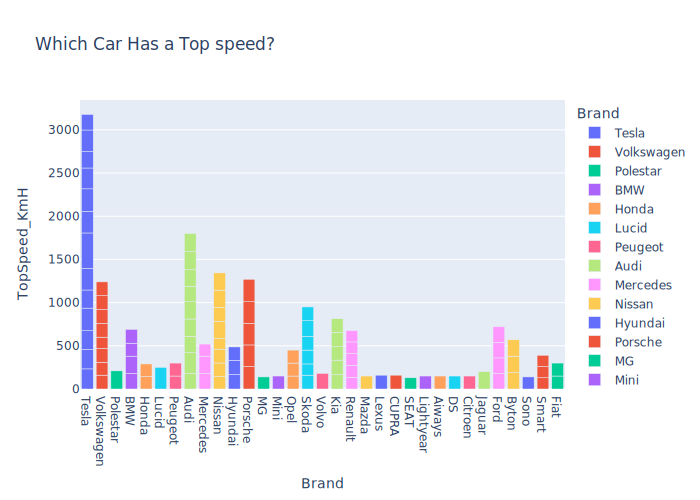

In [10]:
fig = px.bar(df,x='Brand',y = 'TopSpeed_KmH',color = 'Brand',title = 'Which Car Has a Top speed?',labels = {'x':'Car Brands','y':'Top Speed Km/H'})
pio.show(fig)

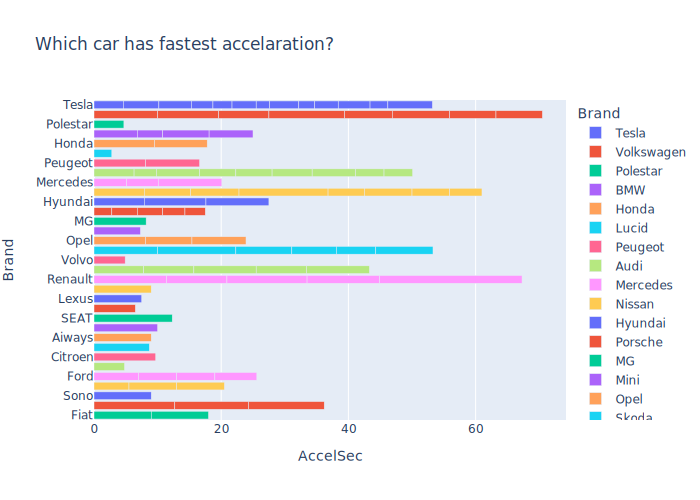

In [11]:
fig = px.bar(df,x='AccelSec',y = 'Brand',color = 'Brand',title = 'Which car has fastest accelaration?',labels = {'x':'Accelaration','y':'Car Brands'})
pio.show(fig)

<Axes: title={'center': 'Car Price'}, xlabel='No. of Samples', ylabel='Car Price'>

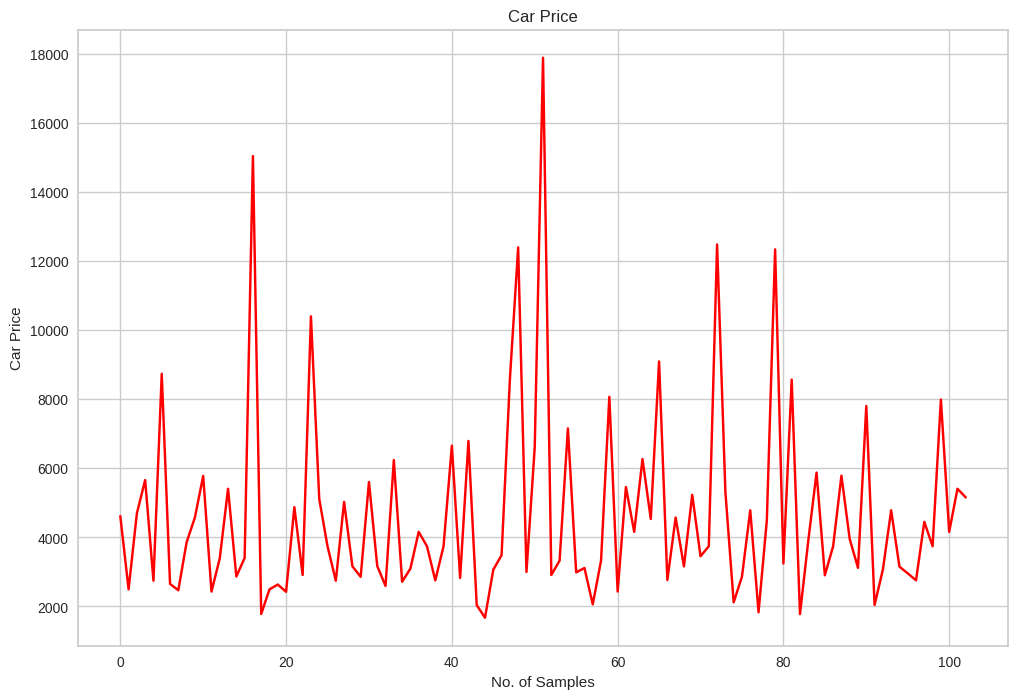

In [12]:
df['inr(10e3)'].plot(figsize = (12,8),title='Car Price',xlabel = 'No. of Samples',ylabel = 'Car Price',color = 'red')

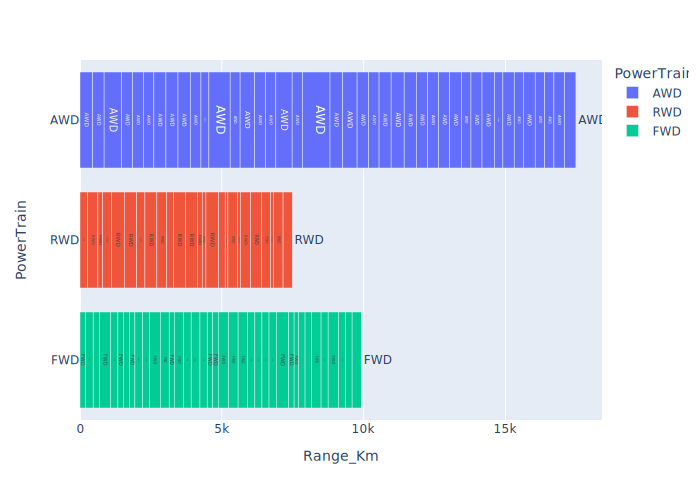

In [13]:
fig = px.bar(df,x = 'Range_Km',y = 'PowerTrain',color = 'PowerTrain',text='PowerTrain')
pio.show(fig)

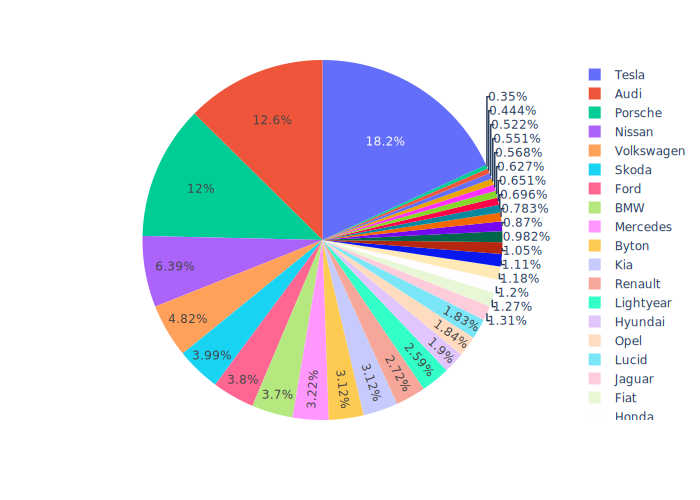

In [14]:
fig = px.pie(df,names = 'Brand',values = 'inr(10e3)')
pio.show(fig)

In [15]:
fig = px.scatter_3d(df,x = 'Brand',y = 'Seats',z = 'Segment',color='Brand')

In [16]:
fig = px.scatter_3d(df,x = 'Brand',y = 'AccelSec',z = 'inr(10e3)',color = 'Brand')

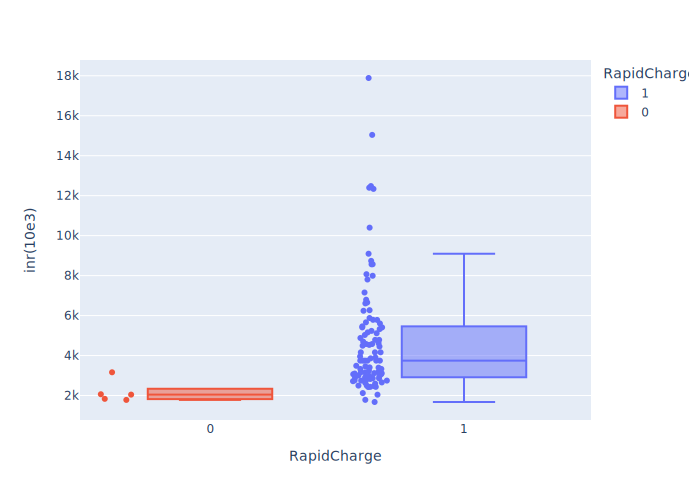

In [17]:
fig = px.box(df,x='RapidCharge',y = 'inr(10e3)',color = 'RapidCharge',points='all')
pio.show(fig)

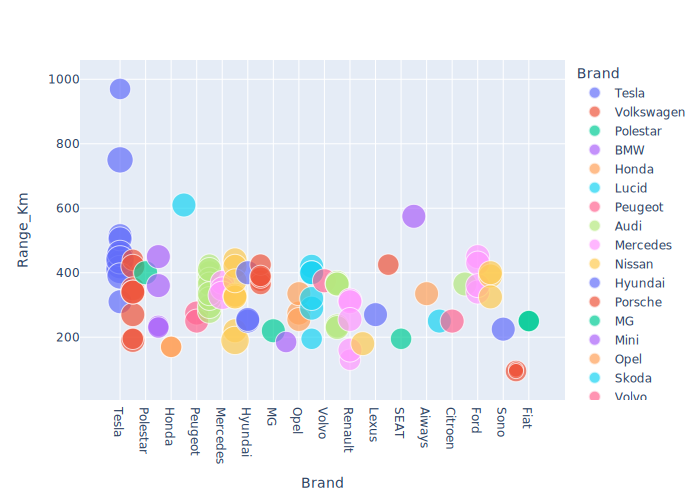

In [18]:
fig = px.scatter(df,x = 'Brand',y = 'Range_Km',size='Seats',color = 'Brand',hover_data=['RapidCharge','inr(10e3)'])
pio.show(fig)

## Pairplot of all the columns based on Rapid Charger presence

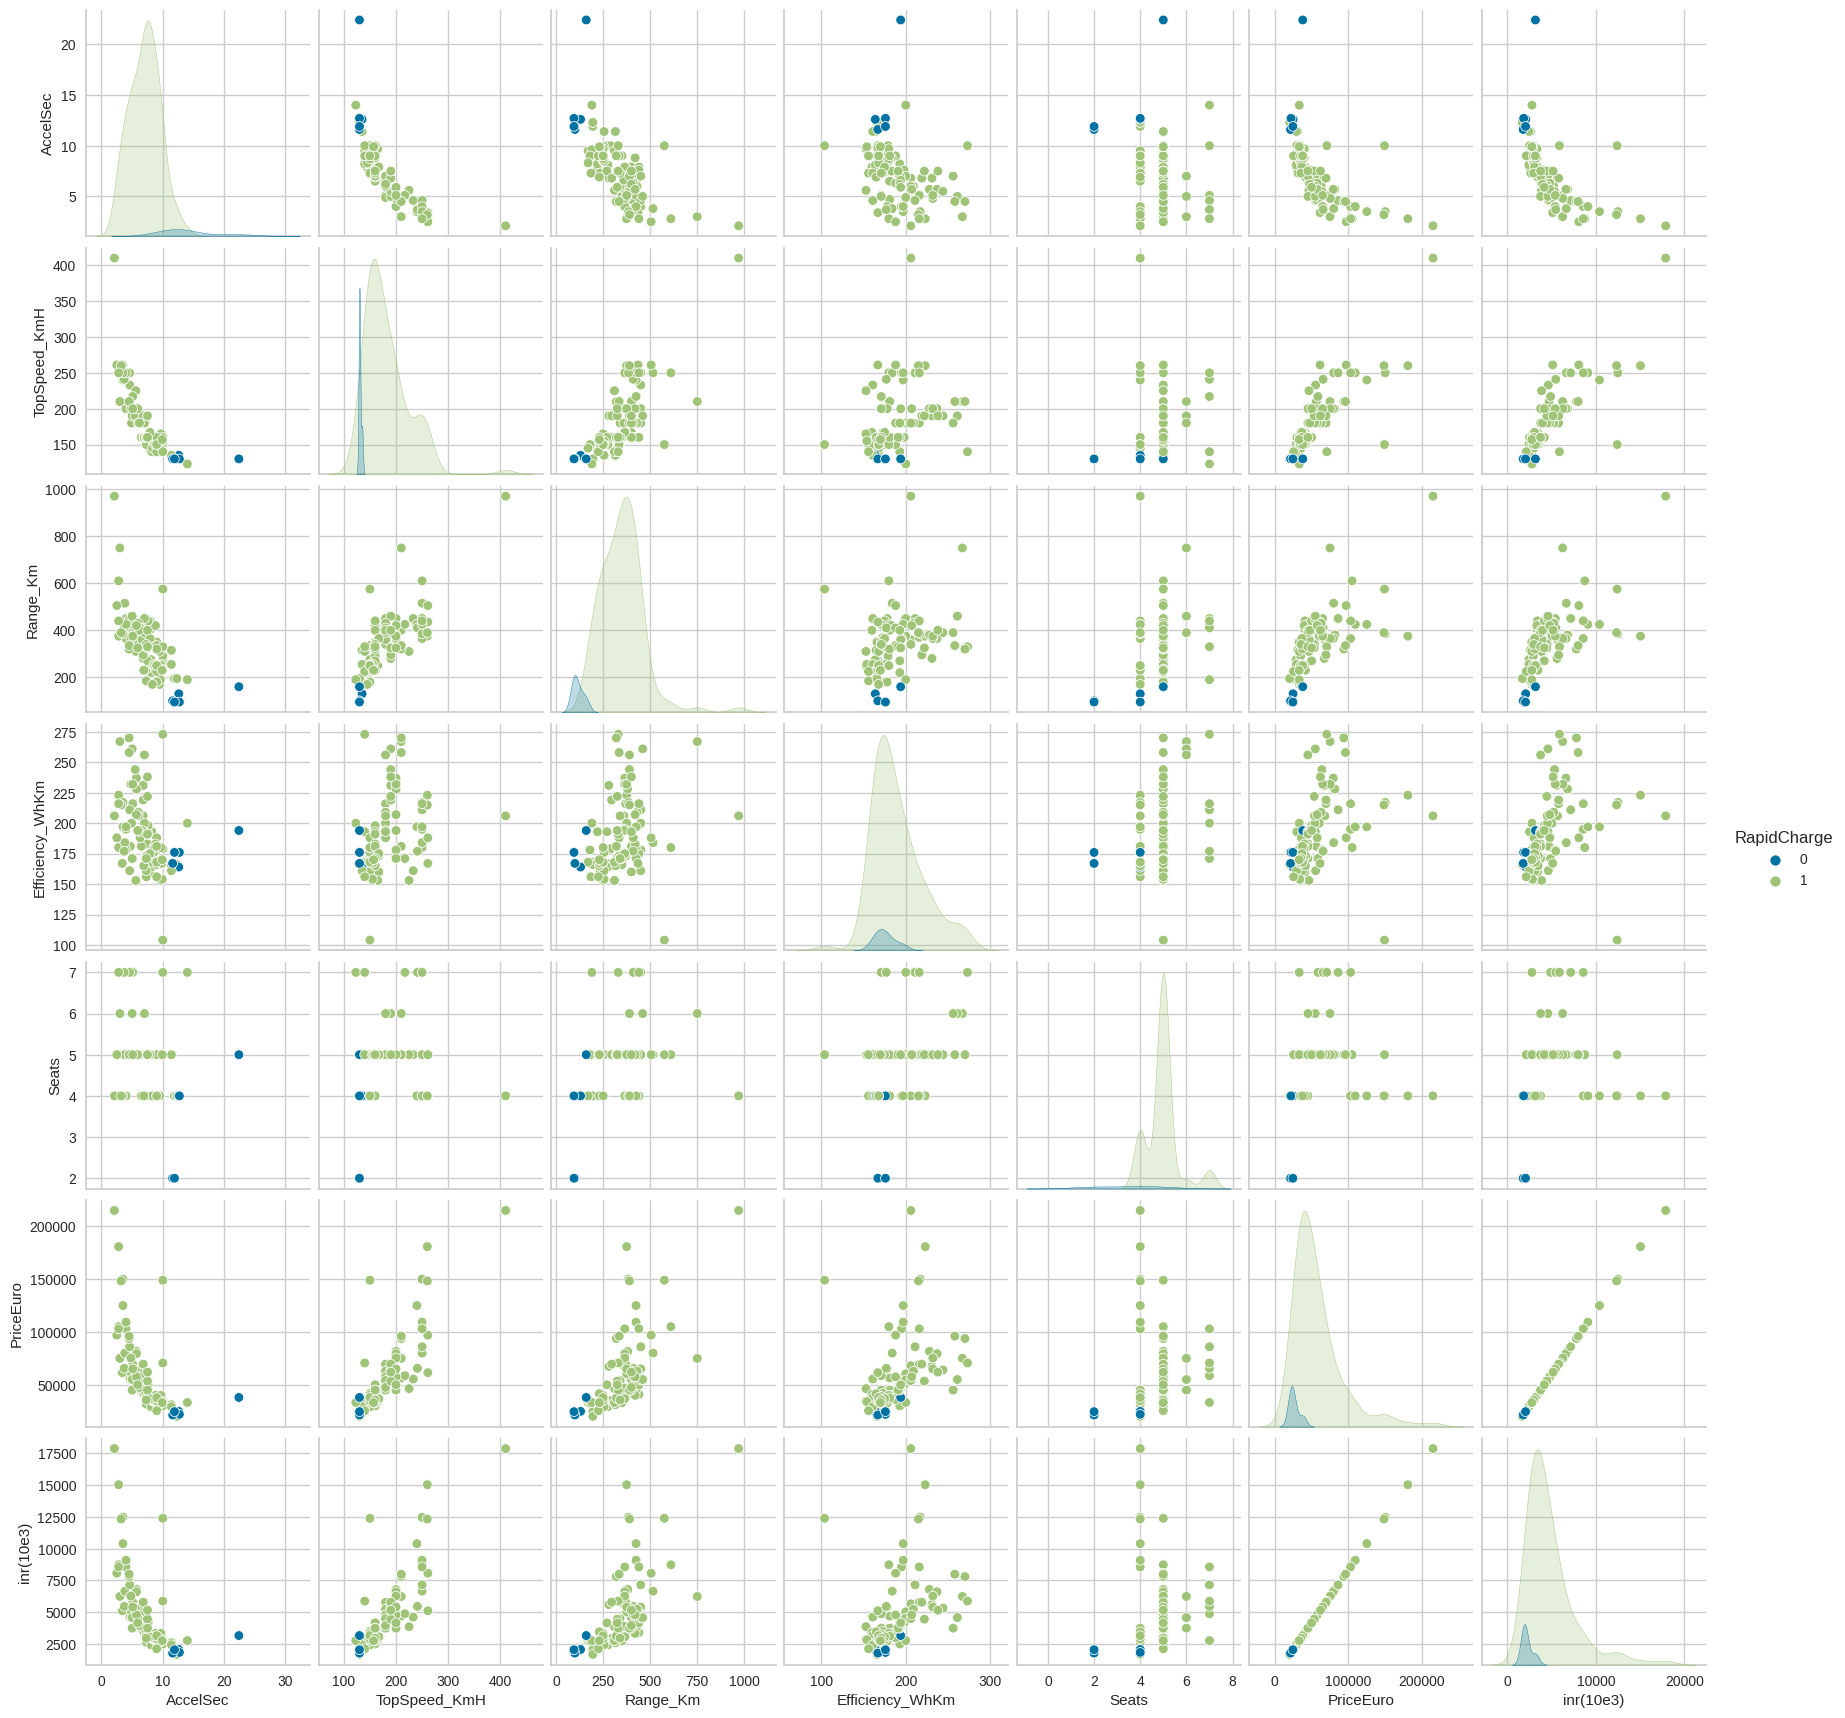

In [19]:
sb.pairplot(df,hue='RapidCharge')

## Heatmap to show the correlation of the data

<ipython-input-20-ac0745e1c6f5>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

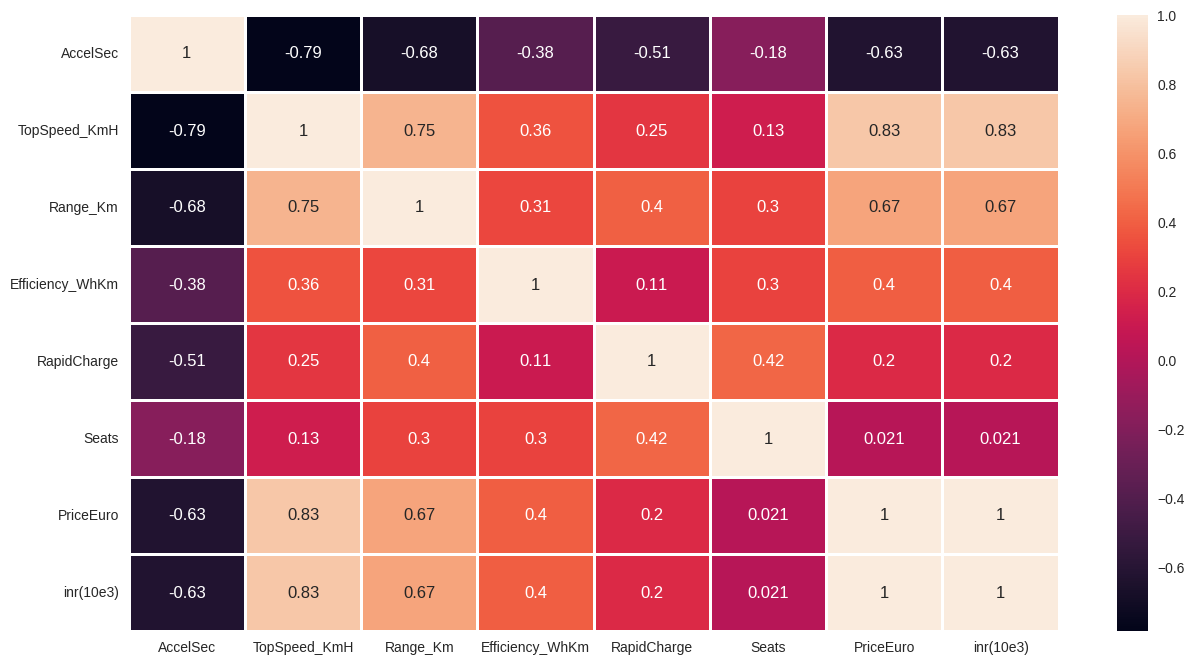

In [20]:
ax= plt.figure(figsize=(15,8))
sb.heatmap(df.corr(),linewidths=1,linecolor='white',annot=True)

In [21]:
a=np.arange(1,104)

# Making Some Comparisions for our dataset


## Frequency of the Brands in the dataset

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

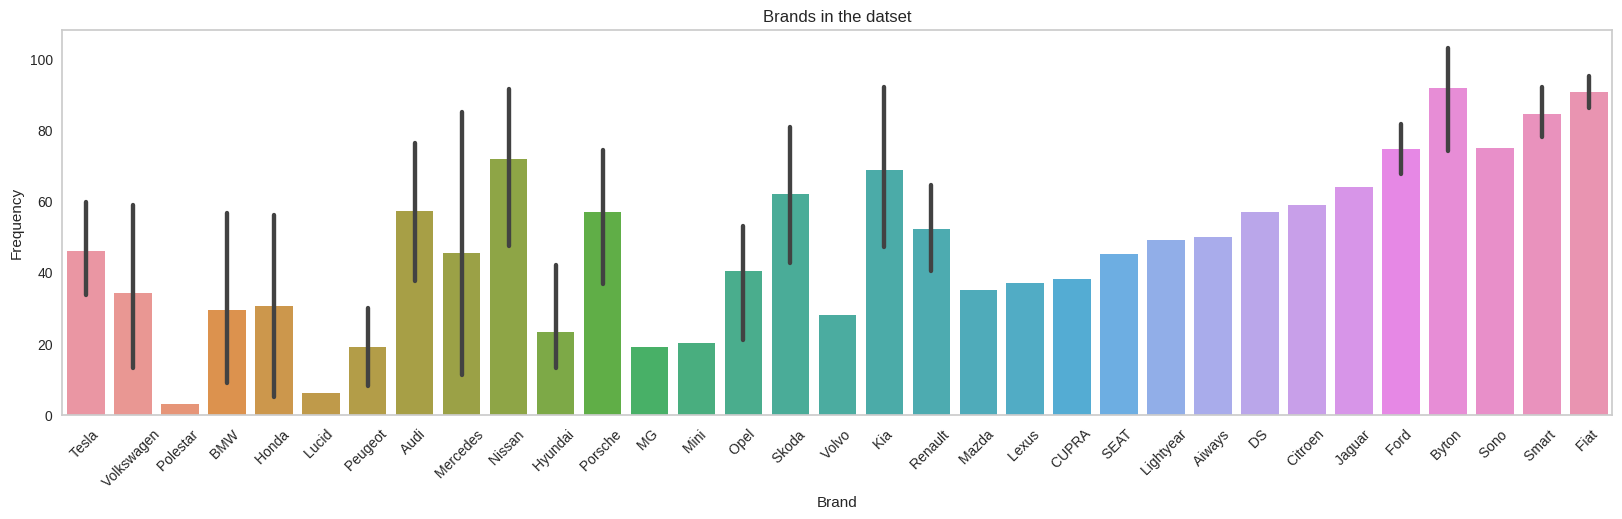

In [22]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y=a,data=df)
plt.grid(axis='y')
plt.title('Brands in the datset')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

Byton , Fiat and smart are the prominent brands and Polestar being the least


## Top speeds achieved by the cars of a brand

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

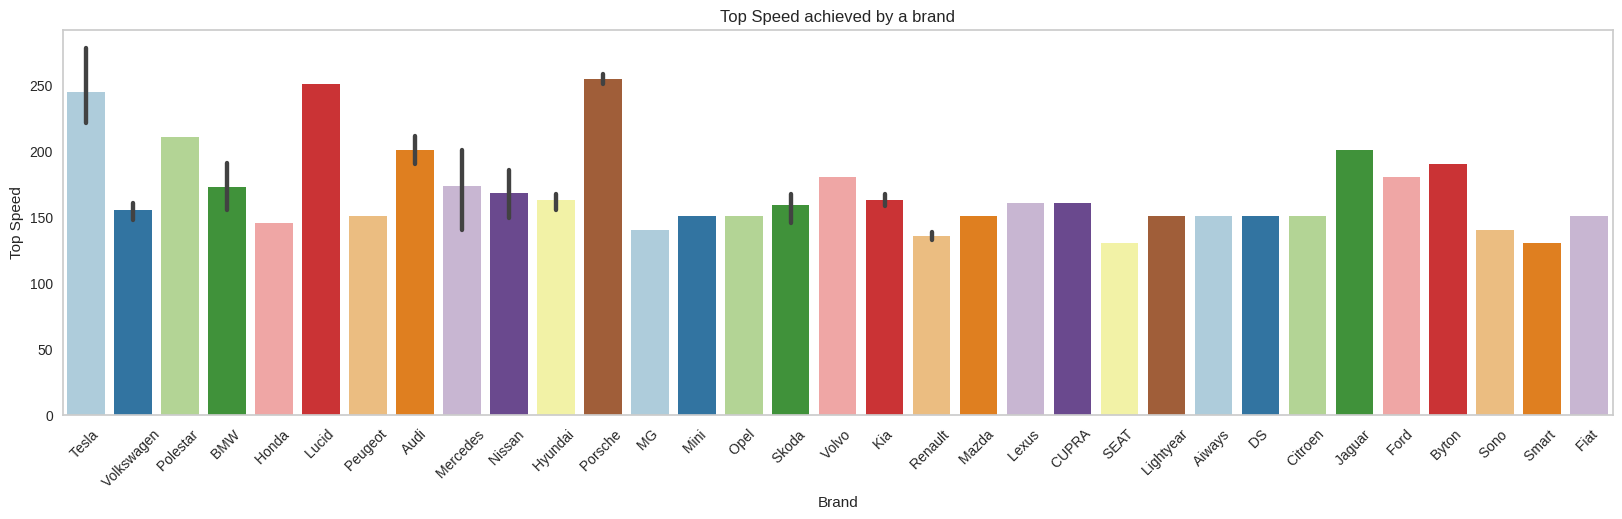

In [23]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='TopSpeed_KmH',data=df,palette='Paired')
plt.grid(axis='y')
plt.title('Top Speed achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Top Speed')
plt.xticks(rotation=45)

Porsche, Lucid and Tesla produce the fastest cars and Smart the lowest


## Range a car can achieve

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

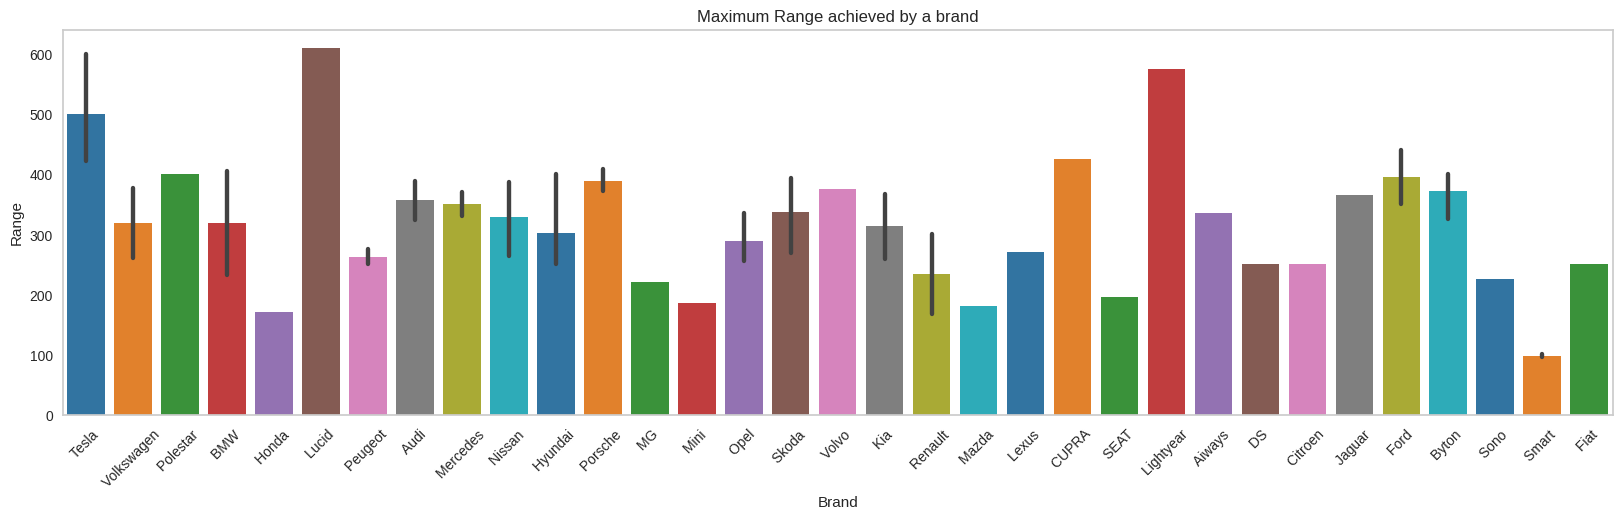

In [24]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Range_Km',data=df,palette='tab10')
plt.grid(axis='y')
plt.title('Maximum Range achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Range')
plt.xticks(rotation=45)

Lucid, Lightyear and Tesla have the highest range and Smart the lowest

## Car efficiency

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

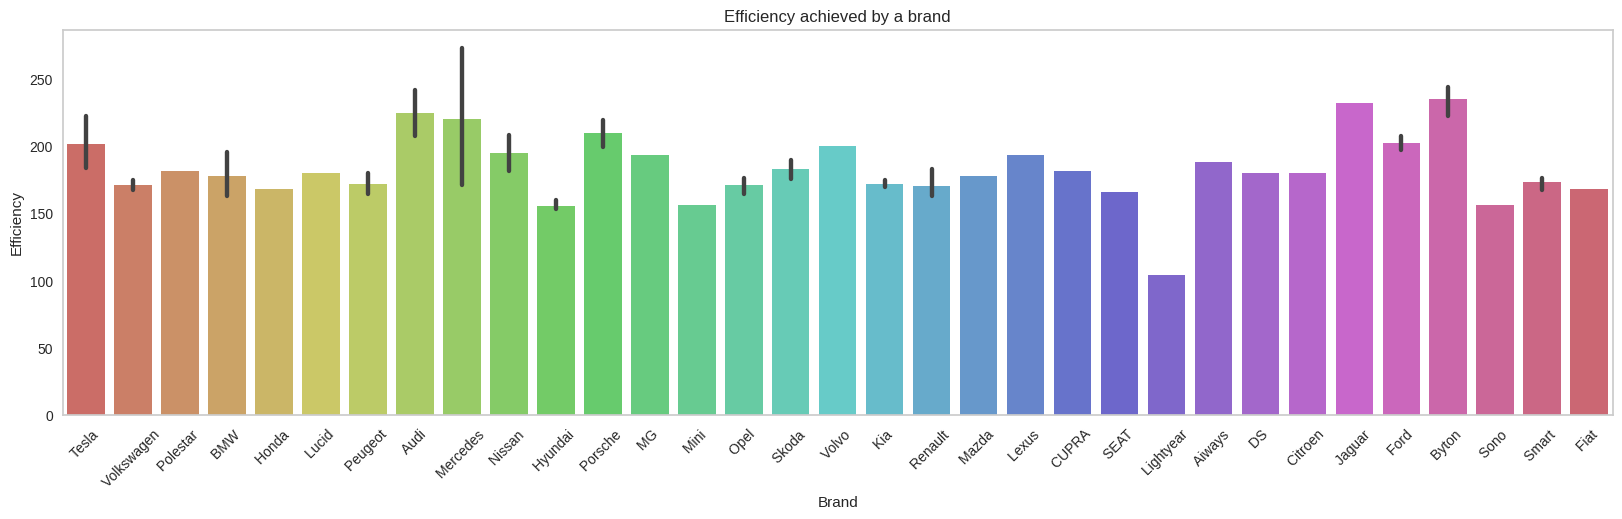

In [25]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Efficiency_WhKm',data=df,palette='hls')
plt.grid(axis='y')
plt.title('Efficiency achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Efficiency')
plt.xticks(rotation=45)

Byton , Jaguar and Audi are the most efficient and Lightyear the least

## Number of seats in each car

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

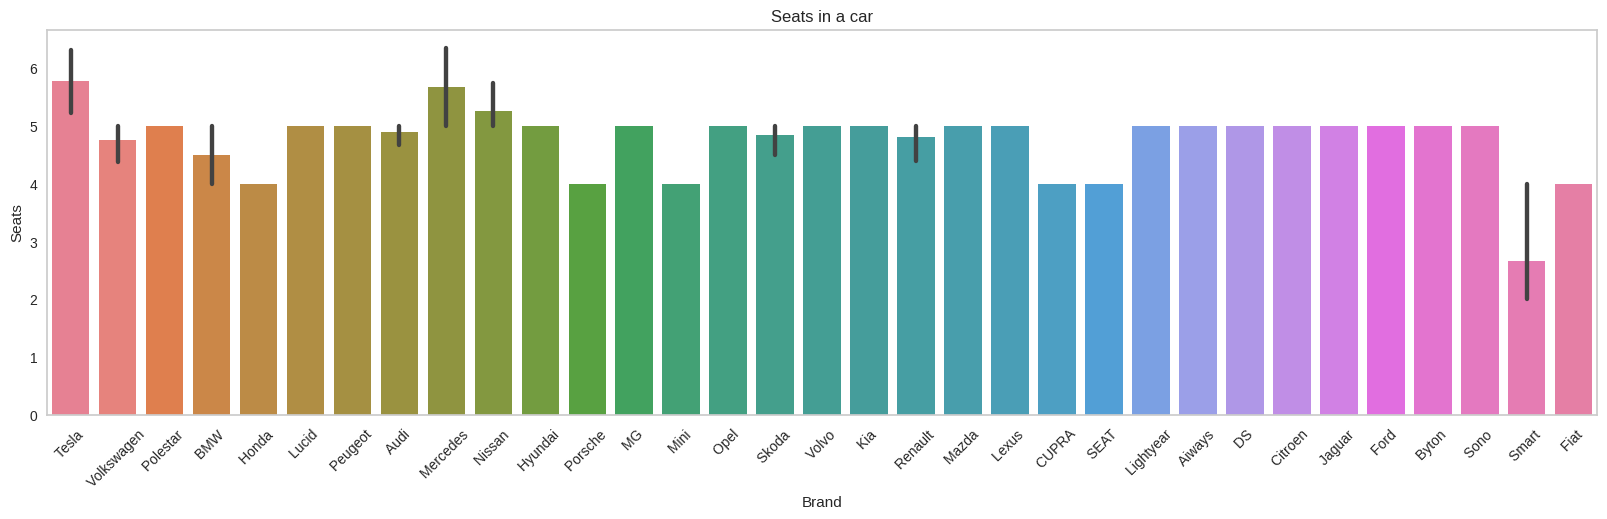

In [26]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Seats',data=df,palette='husl')
plt.grid(axis='y')
plt.title('Seats in a car')
plt.xlabel('Brand')
plt.ylabel('Seats')
plt.xticks(rotation=45)

Mercedes, Tesla and Nissan have the highest number of seats and Smart the lowest

## Price of cars (in INR)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32, 0, 'Fiat ')])

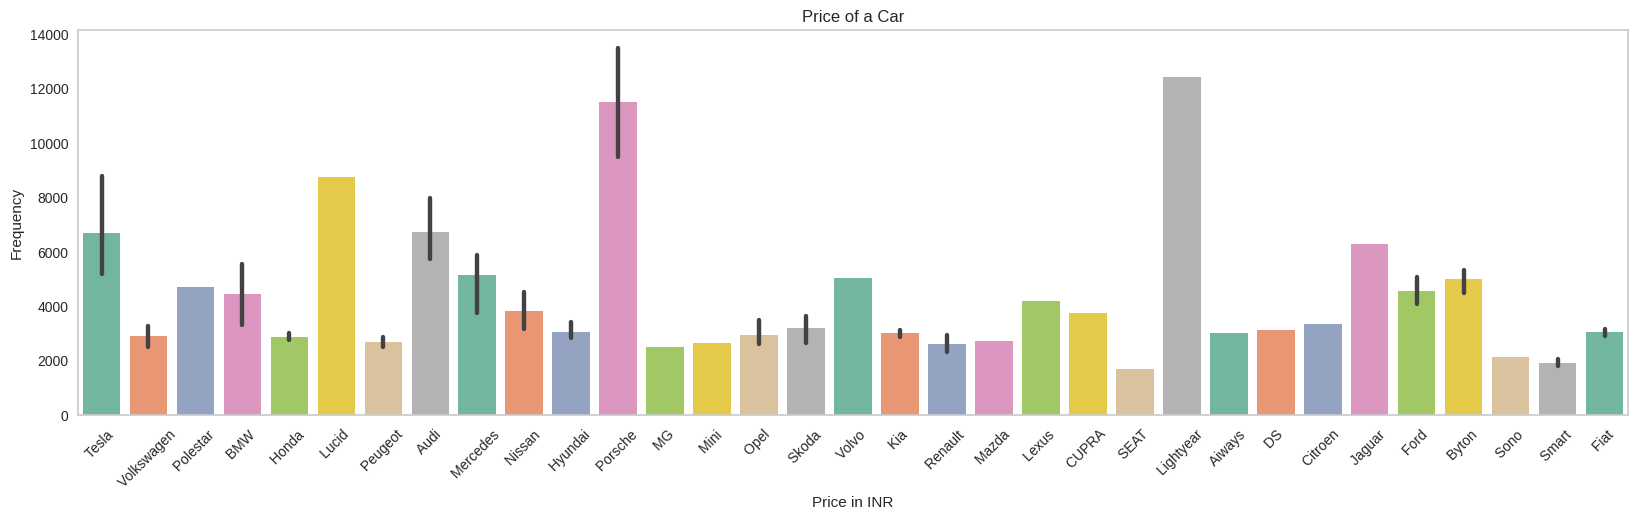

In [27]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='inr(10e3)',data=df,palette='Set2')
plt.title('Price of a Car')
plt.xlabel('Price in INR')
plt.grid(axis='y')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

Lightyear, Porsche and Lucid are the most expensive and SEAT and Smart the least

## Type of Plug used for charging

Text(0.5, 1.0, 'Plug Type')

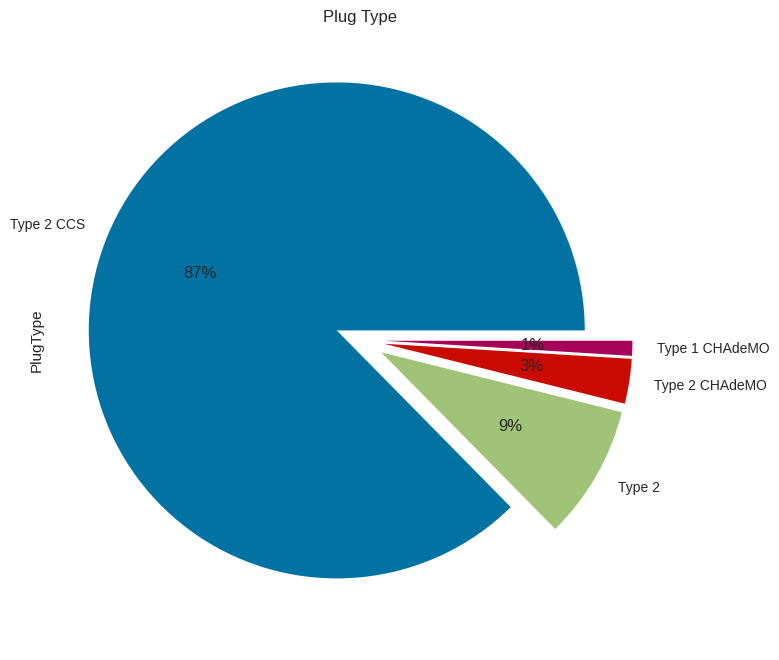

In [28]:
df['PlugType'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(.1,.1,.1,.1))
plt.title('Plug Type')

Most companies use Type 2 CCS and Type 1 CHAdeMo the least

## Cars and their body style

Text(0.5, 1.0, 'Body Style')

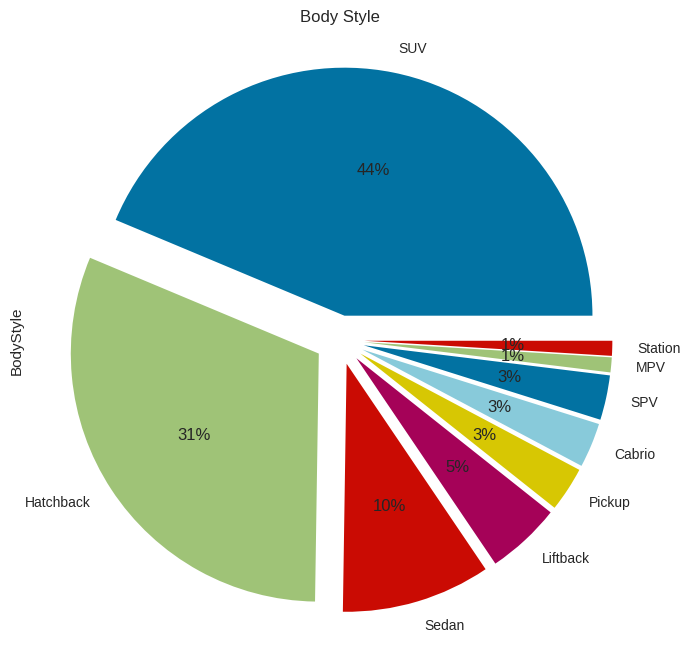

In [29]:
df['BodyStyle'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Body Style')

Most cars are eiher SUV or Hatchback

## Segment in which the cars fall under

Text(0.5, 1.0, 'Segment')

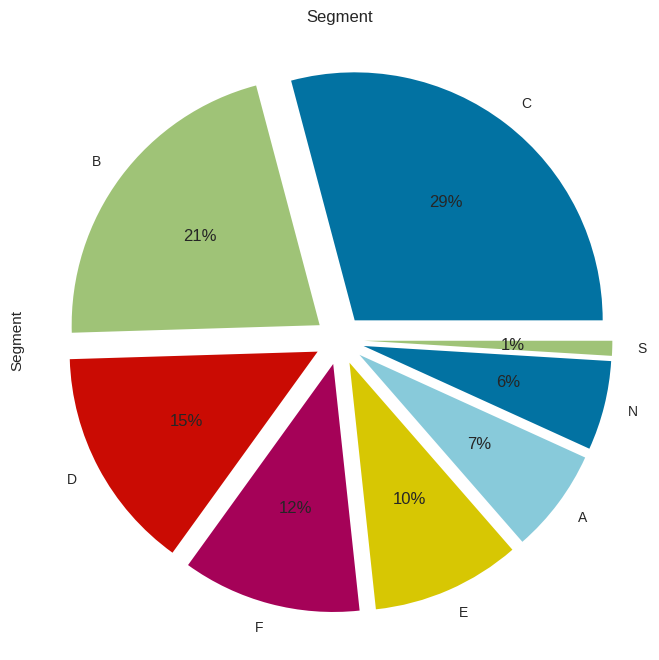

In [30]:
df['Segment'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Segment')

Most cars are either C or B type

## Number of Seats

Text(0.5, 1.0, 'Seats')

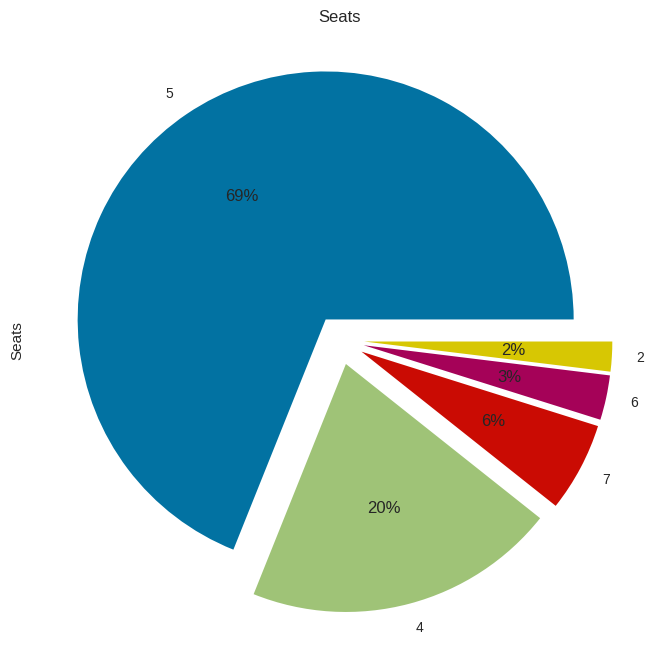

In [31]:
df['Seats'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1))
plt.title('Seats')

Majority of cars have 5 seats

In [32]:
df3= df[["TopSpeed_KmH", "inr(10e3)"]].groupby("TopSpeed_KmH").count()
df4= df[["Range_Km", "inr(10e3)"]].groupby("Range_Km").count()
df5= df[["Range_Km", "TopSpeed_KmH"]].groupby("Range_Km").count()
df5.head()

,TopSpeed_KmH
Range_Km,
95,2
100,1
130,1
160,1
170,2


In [33]:
df3=df3.sort_values("TopSpeed_KmH",ascending = False).head(10)
df4=df4.sort_values("Range_Km",ascending = False).head(10)
df5=df5.sort_values("Range_Km",ascending = False).head(10)

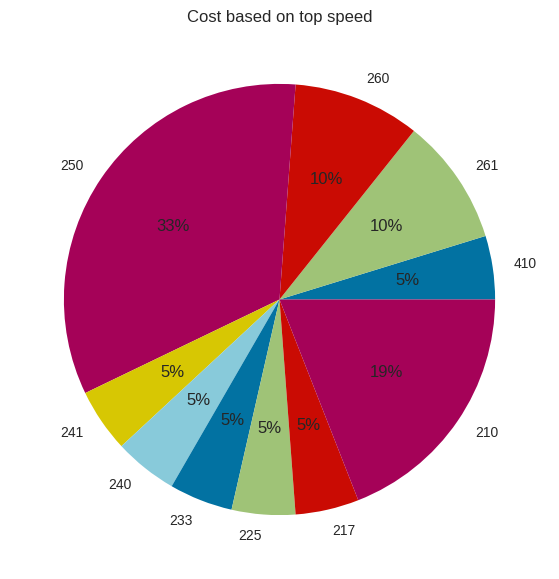

In [34]:
plt.figure(figsize=(10,7))
plt.title('Cost based on top speed')
plt.pie(x=df3["inr(10e3)"],labels=df3.index,autopct='%1.0f%%')
plt.show()

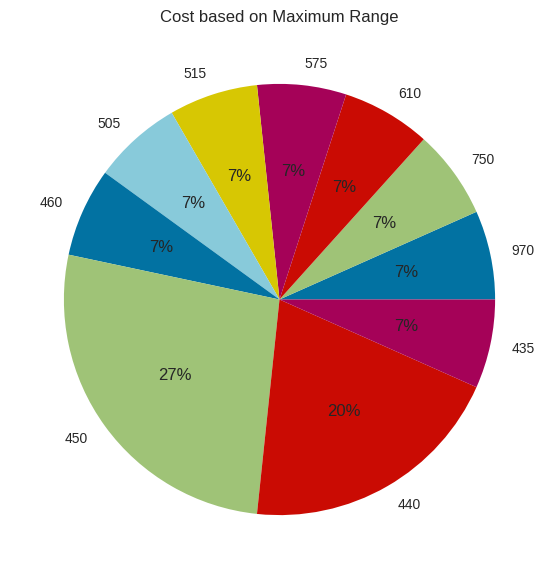

In [35]:
plt.figure(figsize=(10,7))
plt.title('Cost based on Maximum Range')
plt.pie(x=df4["inr(10e3)"],labels=df4.index,autopct='%1.0f%%')
plt.show()

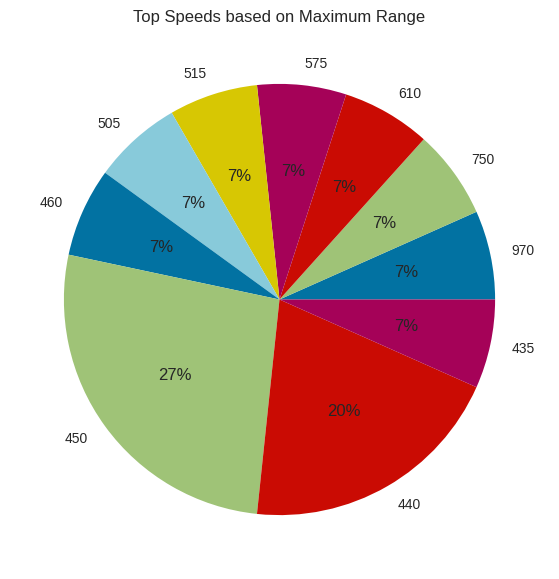

In [36]:
plt.figure(figsize=(10,7))
plt.title('Top Speeds based on Maximum Range')
plt.pie(x=df5["TopSpeed_KmH"],labels=df5.index,autopct='%1.0f%%')
plt.show()

# Regression

## Putting independent variables as x and dependent variable as y

In [37]:
df['PowerTrain'].replace(to_replace=['RWD','AWD','FWD'],value=[0, 2,1],inplace=True)
x=df[['AccelSec','Range_Km','TopSpeed_KmH','Efficiency_WhKm', 'RapidCharge','PowerTrain']]
y=df['PriceEuro']

## Finding out the linear regression using OLS method

In [38]:
x= sm.add_constant(x)
results = sm.OLS(y,x)

## Fitting the model and summarizing

In [39]:
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     41.34
Date:                Thu, 13 Jul 2023   Prob (F-statistic):           1.60e-24
Time:                        13:34:53   Log-Likelihood:                -1155.0
No. Observations:                 103   AIC:                             2324.
Df Residuals:                      96   BIC:                             2343.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -9.576e+04   3.04e+04     -3.148      0.002   -1.56e+05   -3.54e+04
AccelSec         1538.7358   1189.961      1.293      0.199    -823.317    3900.789
Range_Km           38.6413     23.362      1.654      0.101      -7.732      85.015
TopSpeed_KmH      570.8864     86.671      6.587      0.000     398.845     742.927
Efficiency_WhKm   112.0050     70.227      1.595      0.114     -27.395     251.405
RapidCharge     -2827.5602   1.09e+04     -0.259      0.796   -2.45e+04    1.88e+04
PowerTrain       5458.2534   2954.494      1.847      0.068    -406.371    1.13e+04
==============================================================================
Omnibus:                       84.153   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              723.603
Skew:                           2.620   Prob(JB):                    7.44e-158
Kurtosis:                      14.881   Cond. No.                     7.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Notes:

1. Standard Errors assume that the covariance matrix of the errors is correctly specified.
2. The condition number is large, 5.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

Only Top Speed and Efficieny are the two variables related to price

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=365)

In [41]:
lr= LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

## Finding out the R-squared value

In [42]:
r2=(r2_score(y_test,pred))
print(r2*100)

78.56505811253689


Around 78% of the dependant variable has been explained by the independant variables

In [43]:
y1=df[['RapidCharge']]
x1=df[['PriceEuro']]

In [44]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2,random_state=365)

In [45]:
log= LogisticRegression()
log.fit(X1_train, y1_train)
pred1 = log.predict(X1_test)
pred1

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Confusion Matrix of the regression

In [46]:
cm = confusion_matrix(y1_test, pred1)
cm

array([[ 0,  1],
       [ 0, 20]])

## Clustering

<Axes: xlabel='TopSpeed_KmH', ylabel='FastCharge_KmH'>

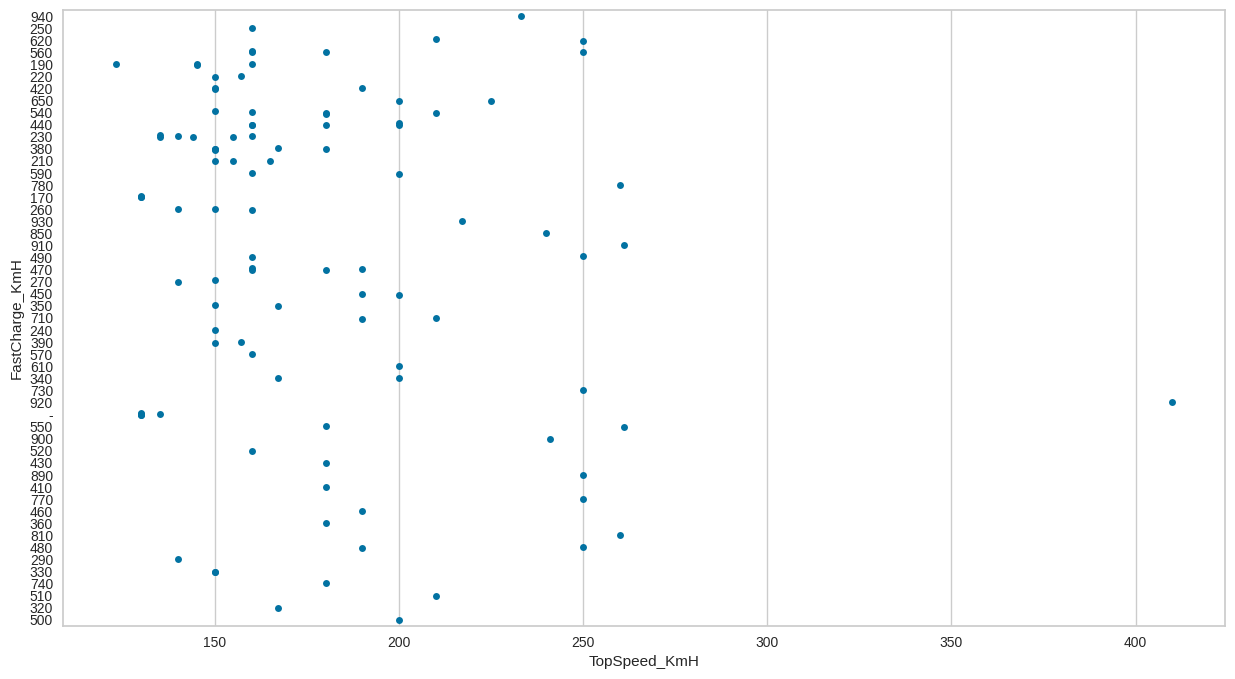

In [47]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='FastCharge_KmH', data=df, jitter=True)

<Axes: xlabel='TopSpeed_KmH', ylabel='Efficiency_WhKm'>

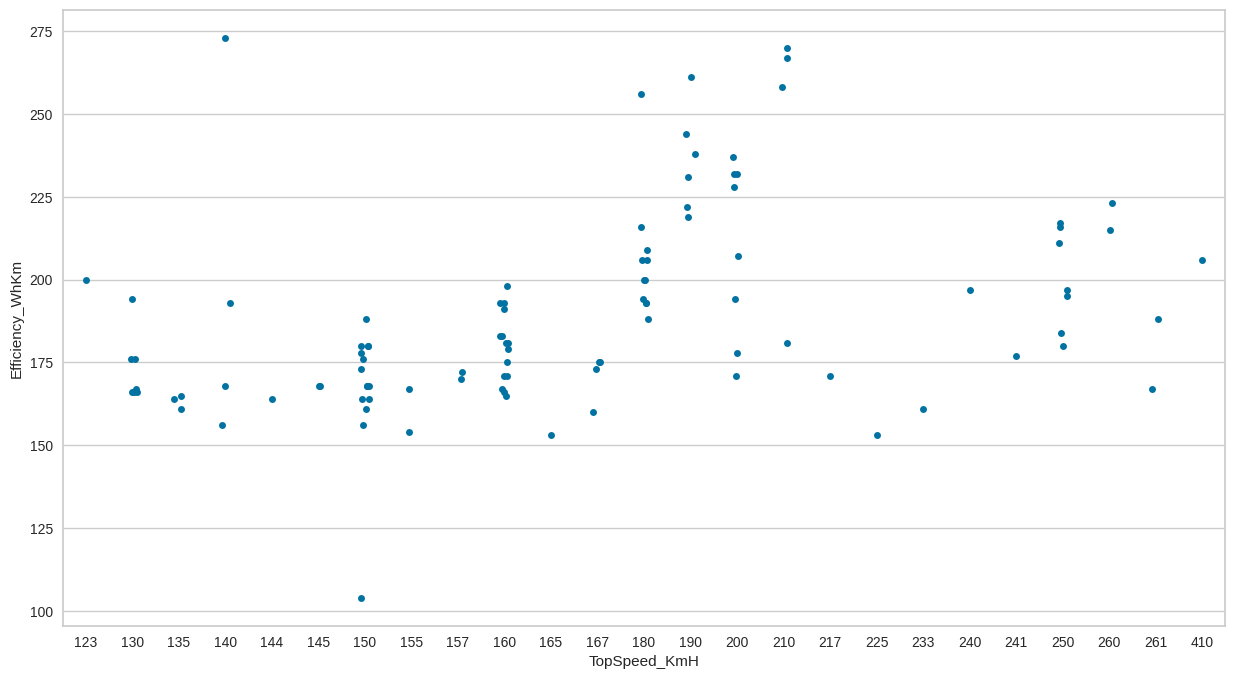

In [48]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='Efficiency_WhKm', data=df, jitter=True)